# **Clusttering seismic events**

## **1. Import Libraries**

In [14]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import folium

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import combinations
from scipy.stats import pearsonr

**Enhance resolution of plot's resolution**

In [15]:
plt.rcParams['path.simplify_threshold'] = 1e-35
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 5000

## **2. Data Processing**

Here we will work with data collected for the past 7 days.

In [16]:
df = pd.read_csv("../data/raw/all_week.csv")

# Ansatz: keep only a few relevant features
reduced_df = df[["latitude","longitude", "depth", "mag"]]

# Feature matrix
X = reduced_df.to_numpy()

# Standarizing the data: mean=0 and std=1
scaler = StandardScaler()
scaler.fit(X)
StandardScaler(copy=True, with_mean=True, with_std=True)
X_scaled = scaler.transform(X)

reduced_df

latitude   longitude    depth   mag
0     35.361167 -117.806167   7.0300  1.84
1     38.792667 -122.723999   2.0800  0.77
2     37.398335 -119.981003  15.3500  2.44
3     33.356167 -116.834333   9.9200  0.62
4     36.033833 -120.187332   8.5700  1.59
...         ...         ...      ...   ...
1601  65.275700 -144.361800   0.0000  1.70
1602  65.282900 -144.370500   3.1000  1.40
1603  61.725200 -149.765100  34.4000  1.70
1604  38.802166 -122.765335   3.8400  0.78
1605  31.660000 -104.179000   7.3303  0.70

[1606 rows x 4 columns]

The idea is to retain only a subset of features to build a baseline model. Further improvements can be achieved by incorporating the remaining features; however, in this stage, we keep the model simple for visualization purposes, leveraging PCA to motivate the exploration of a reduced feature space.

## **3. Data Visualization: Scatter plots**
Scatter plots to measure correlation of features.

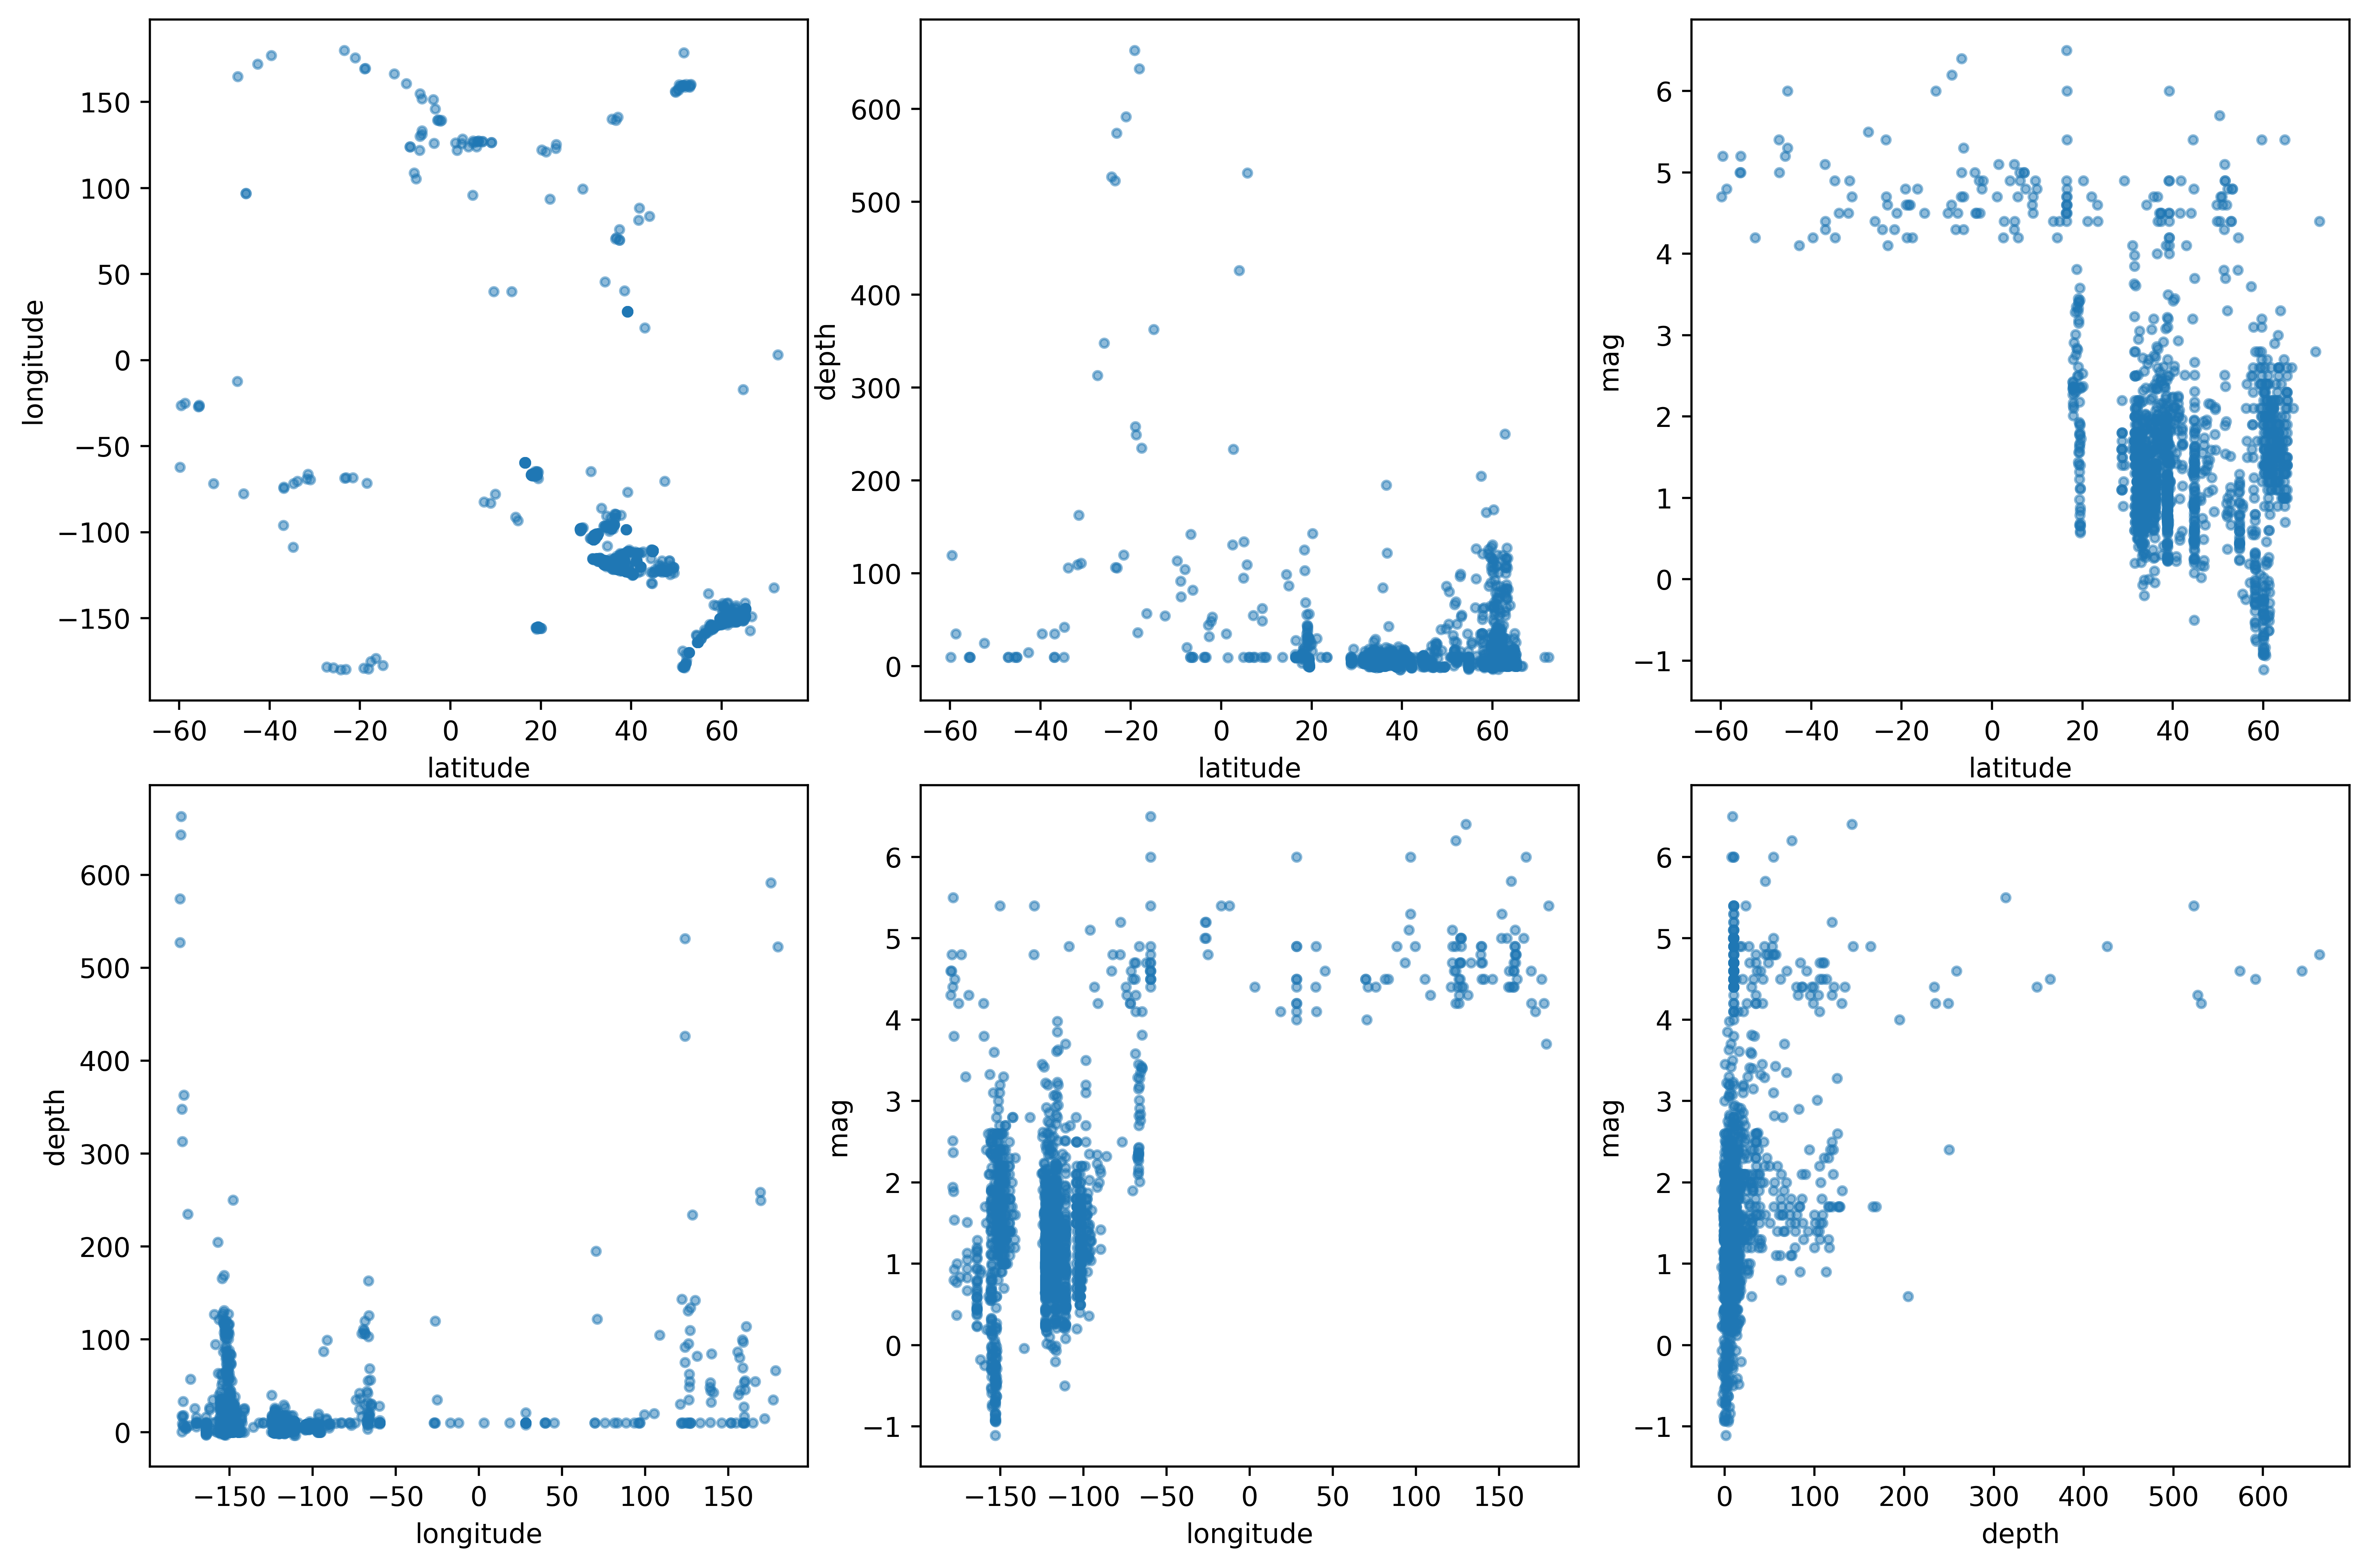

In [17]:
# Generate a list of features combined 2 by 2
features_list = ["latitude", "longitude", "depth", "mag"]
features_list_combination = list(combinations(features_list, 2))

# Grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.tight_layout()

for i, feature_comb in enumerate(features_list_combination):
    # Determine each subplot location
    row = i // 3
    col = i % 3
    
    # Create a scatter plot in the appropriate subplot
    axs[row, col].scatter(reduced_df[feature_comb[0]], reduced_df[feature_comb[1]], s=10, alpha=0.5)
    axs[row, col].set_xlabel(feature_comb[0])
    axs[row, col].set_ylabel(feature_comb[1])

# Display all the subplots together
plt.show()

## **4. Principal Component Analysis (PCA)**
**PCA** analysis follows two main steps 

- Decorrelation, 

- Dimensionality Reduction.

Based on the scatter plots, the features are not strongly correlated. We can measure the strenght of correlations using the **Pearson's correlation coefficient**.

The **Correlation coefficient (r)** measures the strength and the direction of the linear relationship between two numerical variables, if it exists. Its value ranges within $[-1, 1]$, where

- **r > 0** $\rightarrow$ as one variable increases, the other tends to increase as well.

- **r < 0** $\rightarrow$ as one variable increases, the other tends to decrease.

- **r = 0** $\rightarrow$ no linear correlation between the variables.

In [18]:
# Transform the X_scaled into a DataFrame, where each column will be a feature with its label
X_scaled_df = pd.DataFrame(X_scaled, columns=features_list)

# Measuring correlation between the features
for feature_comb in features_list_combination:
    correlation, pvalue = pearsonr(X_scaled_df[feature_comb[0]], X_scaled_df[feature_comb[1]])
    print("Correlation of ({}, {}) = {}".format(feature_comb[0],
         feature_comb[1], correlation))

Correlation of (latitude, longitude) = -0.5035056166984002
Correlation of (latitude, depth) = -0.2348127585096406
Correlation of (latitude, mag) = -0.48108093393181317
Correlation of (longitude, depth) = 0.18344662548335822
Correlation of (longitude, mag) = 0.6500855982838217
Correlation of (depth, mag) = 0.3572190701593491


**PCA** analysis to descorrelate completely the features

- `pca.fit()`: the model learns how to shift and rotate the data,

- `pca.transform()`: implement the shift and rotation of data.

In [19]:
# Here we use the PCA model to descorrelate completely the features
pca = PCA() 
pca.fit(X_scaled) # The pca model learns how to shift and rotate the data
X_pca = pca.transform(X_scaled) # Here the model do the actual transformation learned 

# Correlation between longitude and mag
correlation, pvalue = pearsonr(X_pca[:,1], X_pca[:,3])
correlation


np.float64(1.0802527385670532e-16)

Features with lower variance are treated as noise and disregarded by the **PCA** analysis.

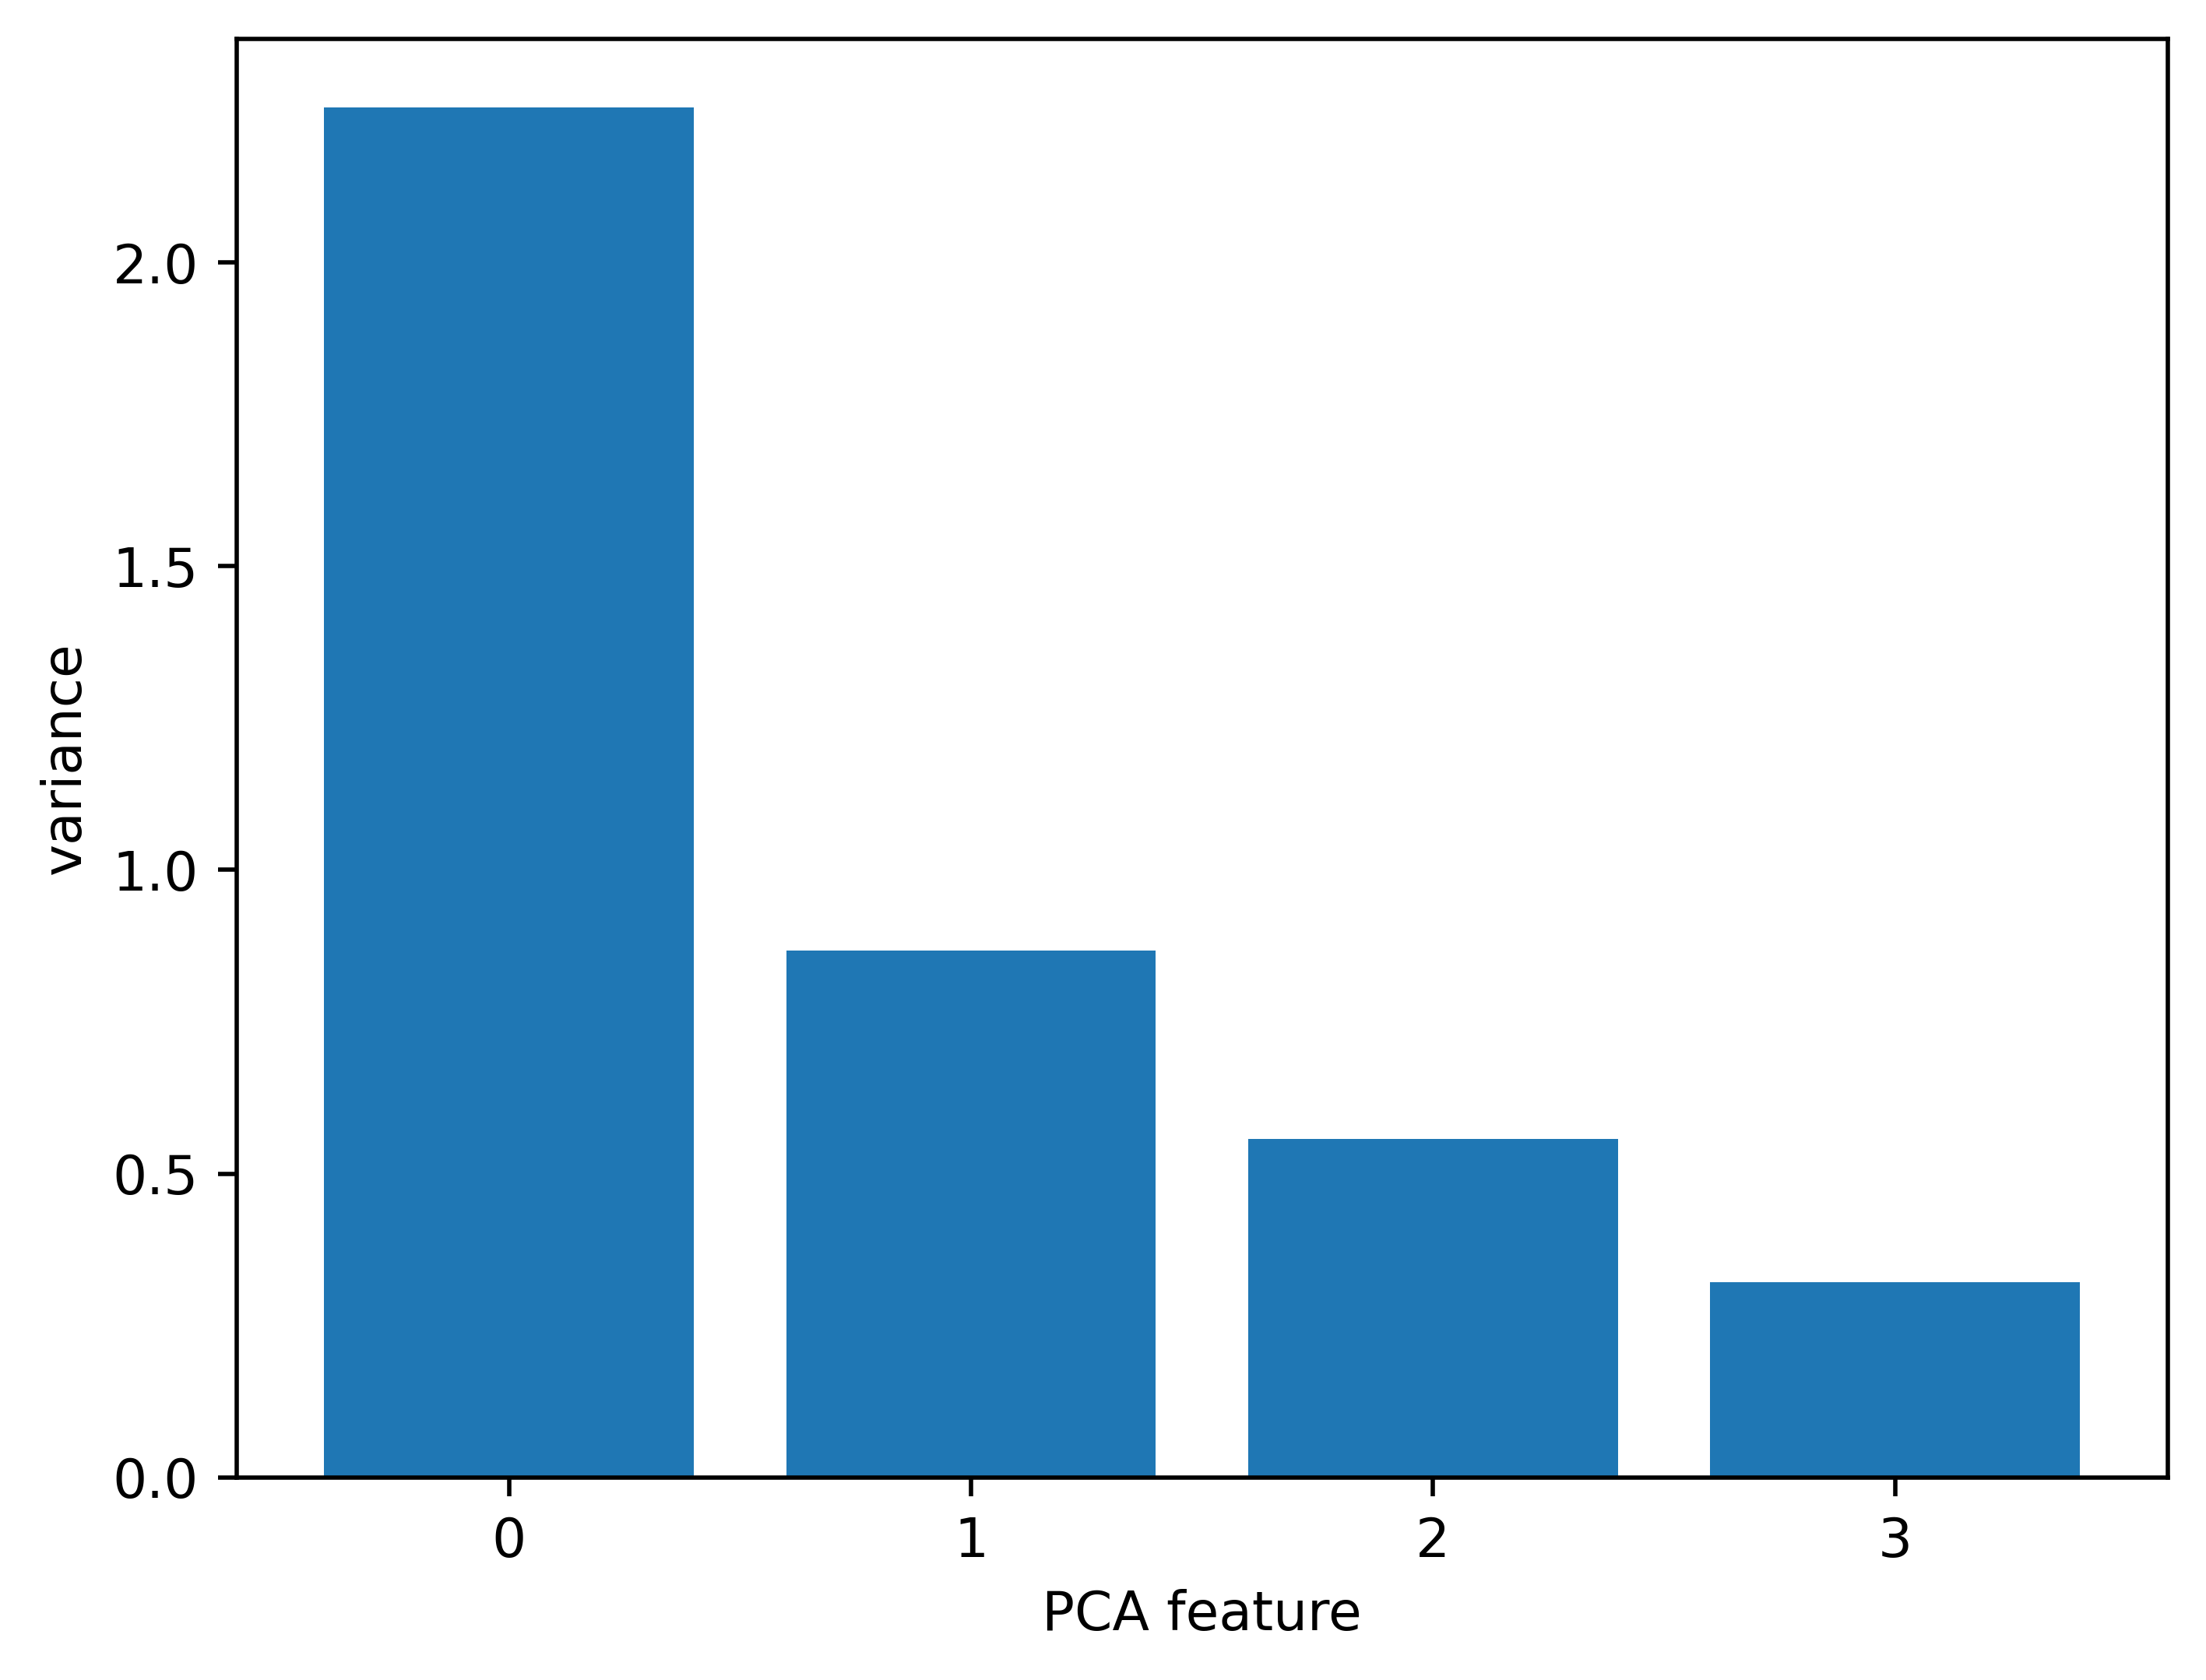

In [20]:
# Bar plot showing the most relevant pca features
features = range(pca.n_components_) # Create an iterable with the number of PCA components
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

The bar plot display the features in descending order of importance.

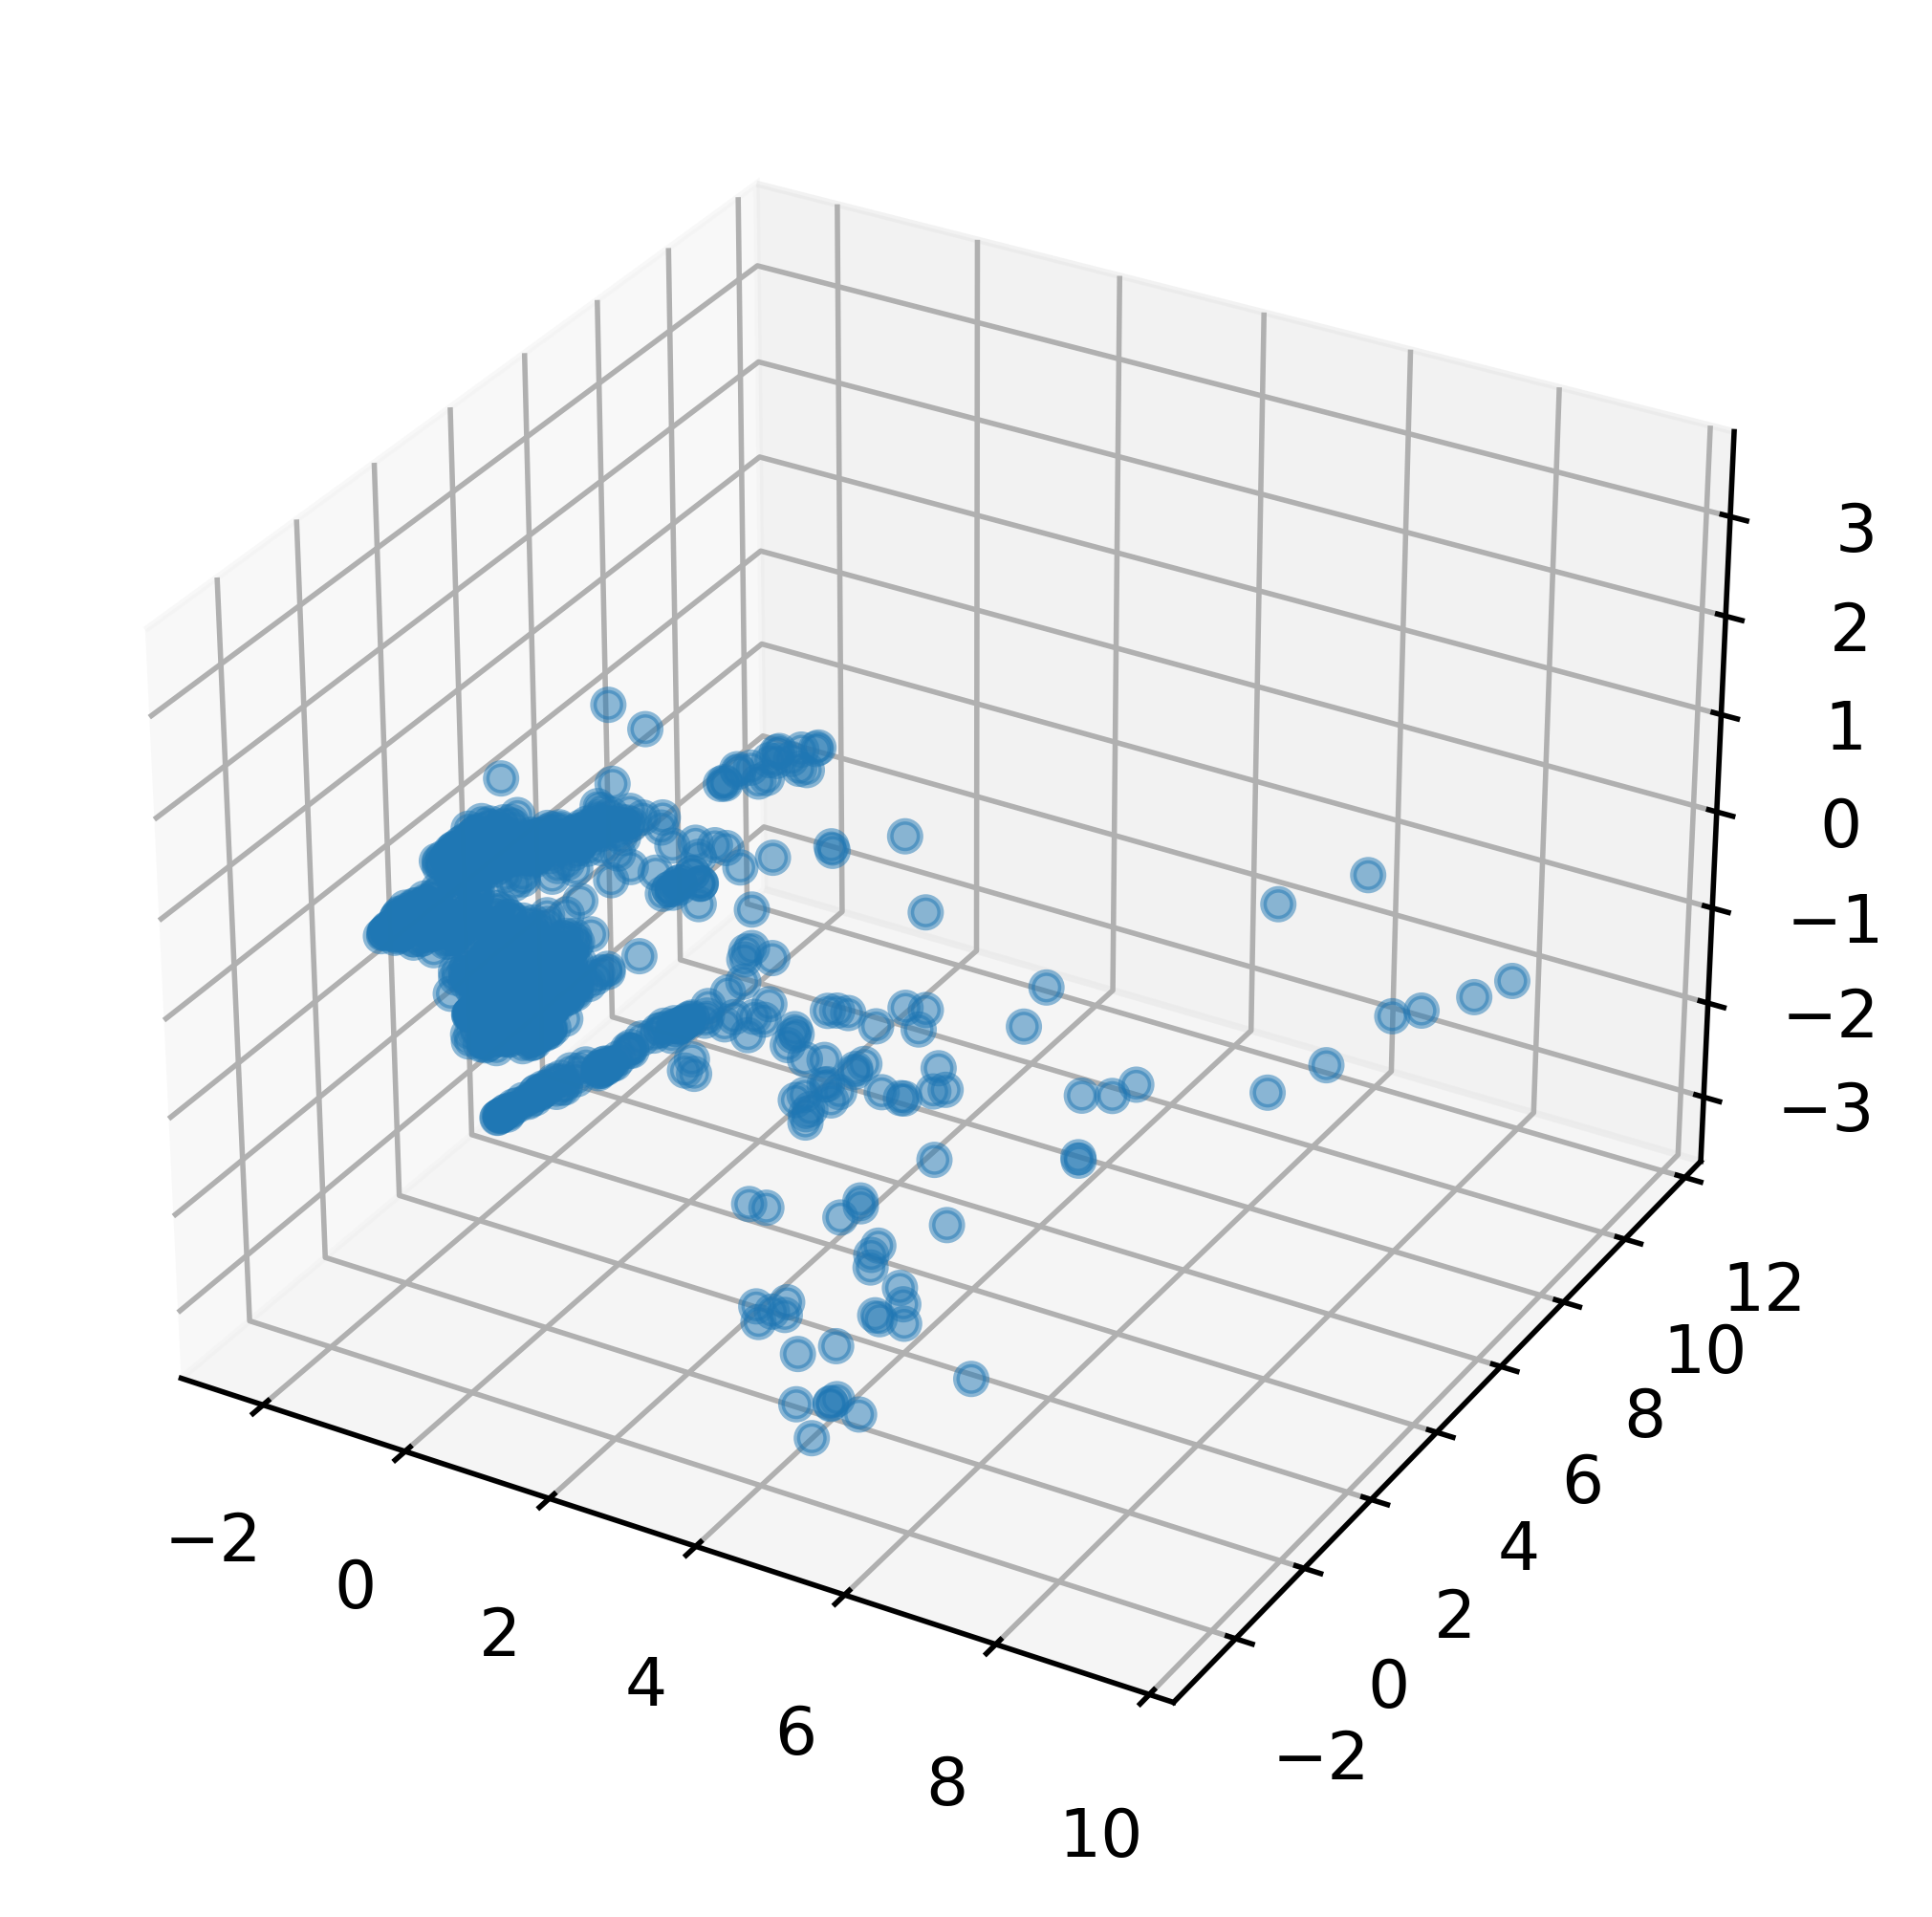

In [21]:
# Reducing the feature space into a 3-dimensional one
pca = PCA(n_components=3)
pca.fit(X_scaled)
transformed_X = pca.transform(X_scaled)

# Plotting the three PCA features with highest variance
xs = transformed_X[:, 0]
ys = transformed_X[:, 1]
zs = transformed_X[:, 2]

fig = plt.figure()
ax = fig.add_subplot( projection='3d')
ax.scatter3D(xs, ys, zs, alpha=0.5)

Removing the noisy feature allows 3d visualization of the new **PCA** feature space. These features are builded as linear combination of the baseline features, and tipically does not represents actual variables with physical meaning.

## **5. KMeans Algorithm**

After applying the **PCA**, we then proceed to the **KMeans** algorithm in order to cluster the features in the reduced 3D space (we could chain the **PCA** along with the KMeans using a pipeline, which will be avoided here for pedagogical reasons). 

We start invoking the `inertia_ attribute` of the **KMeans** model to gain insight on the number of clusters required for the present problem.

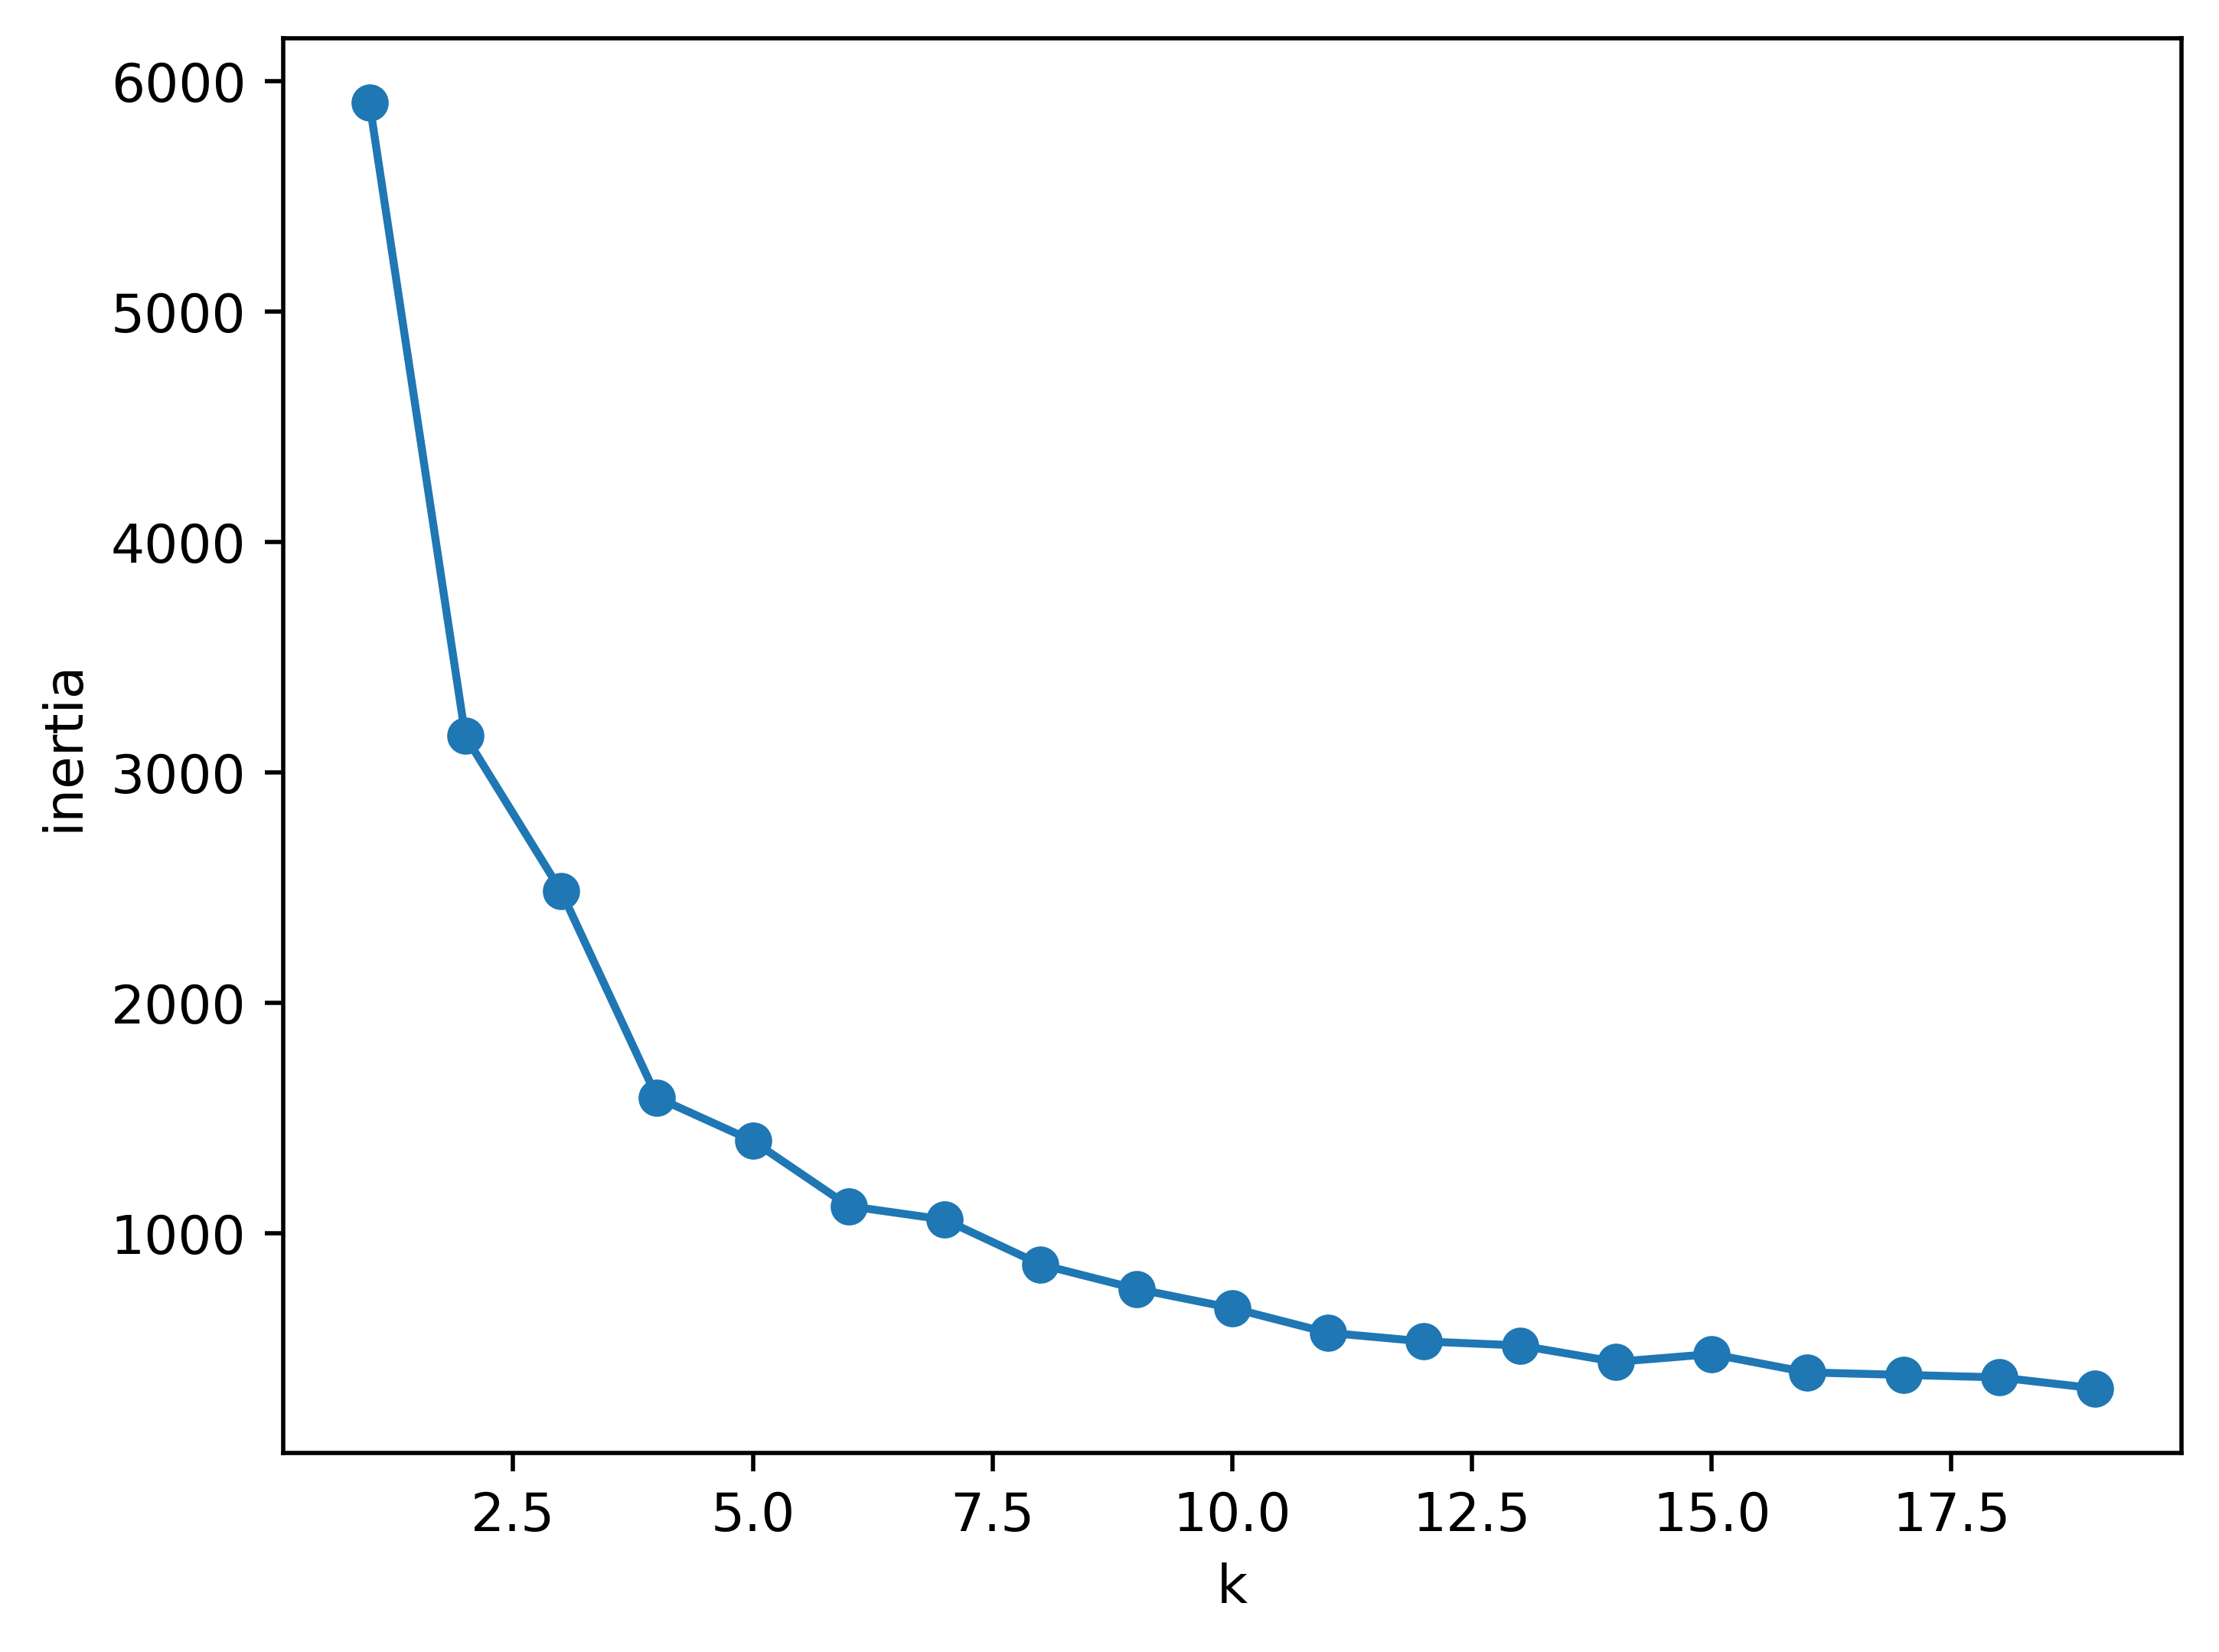

In [22]:
ks = range(1,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(transformed_X)
    inertias.append(model.inertia_)

plt.scatter(ks, inertias, marker='o')
plt.plot(ks, inertias, linestyle='-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

Through the **elbow rule** we need to search the values of k for wich the rate of change drops significantly. This seems to happen between 5 and 7.5, leading to the the optimal choice of k=7.

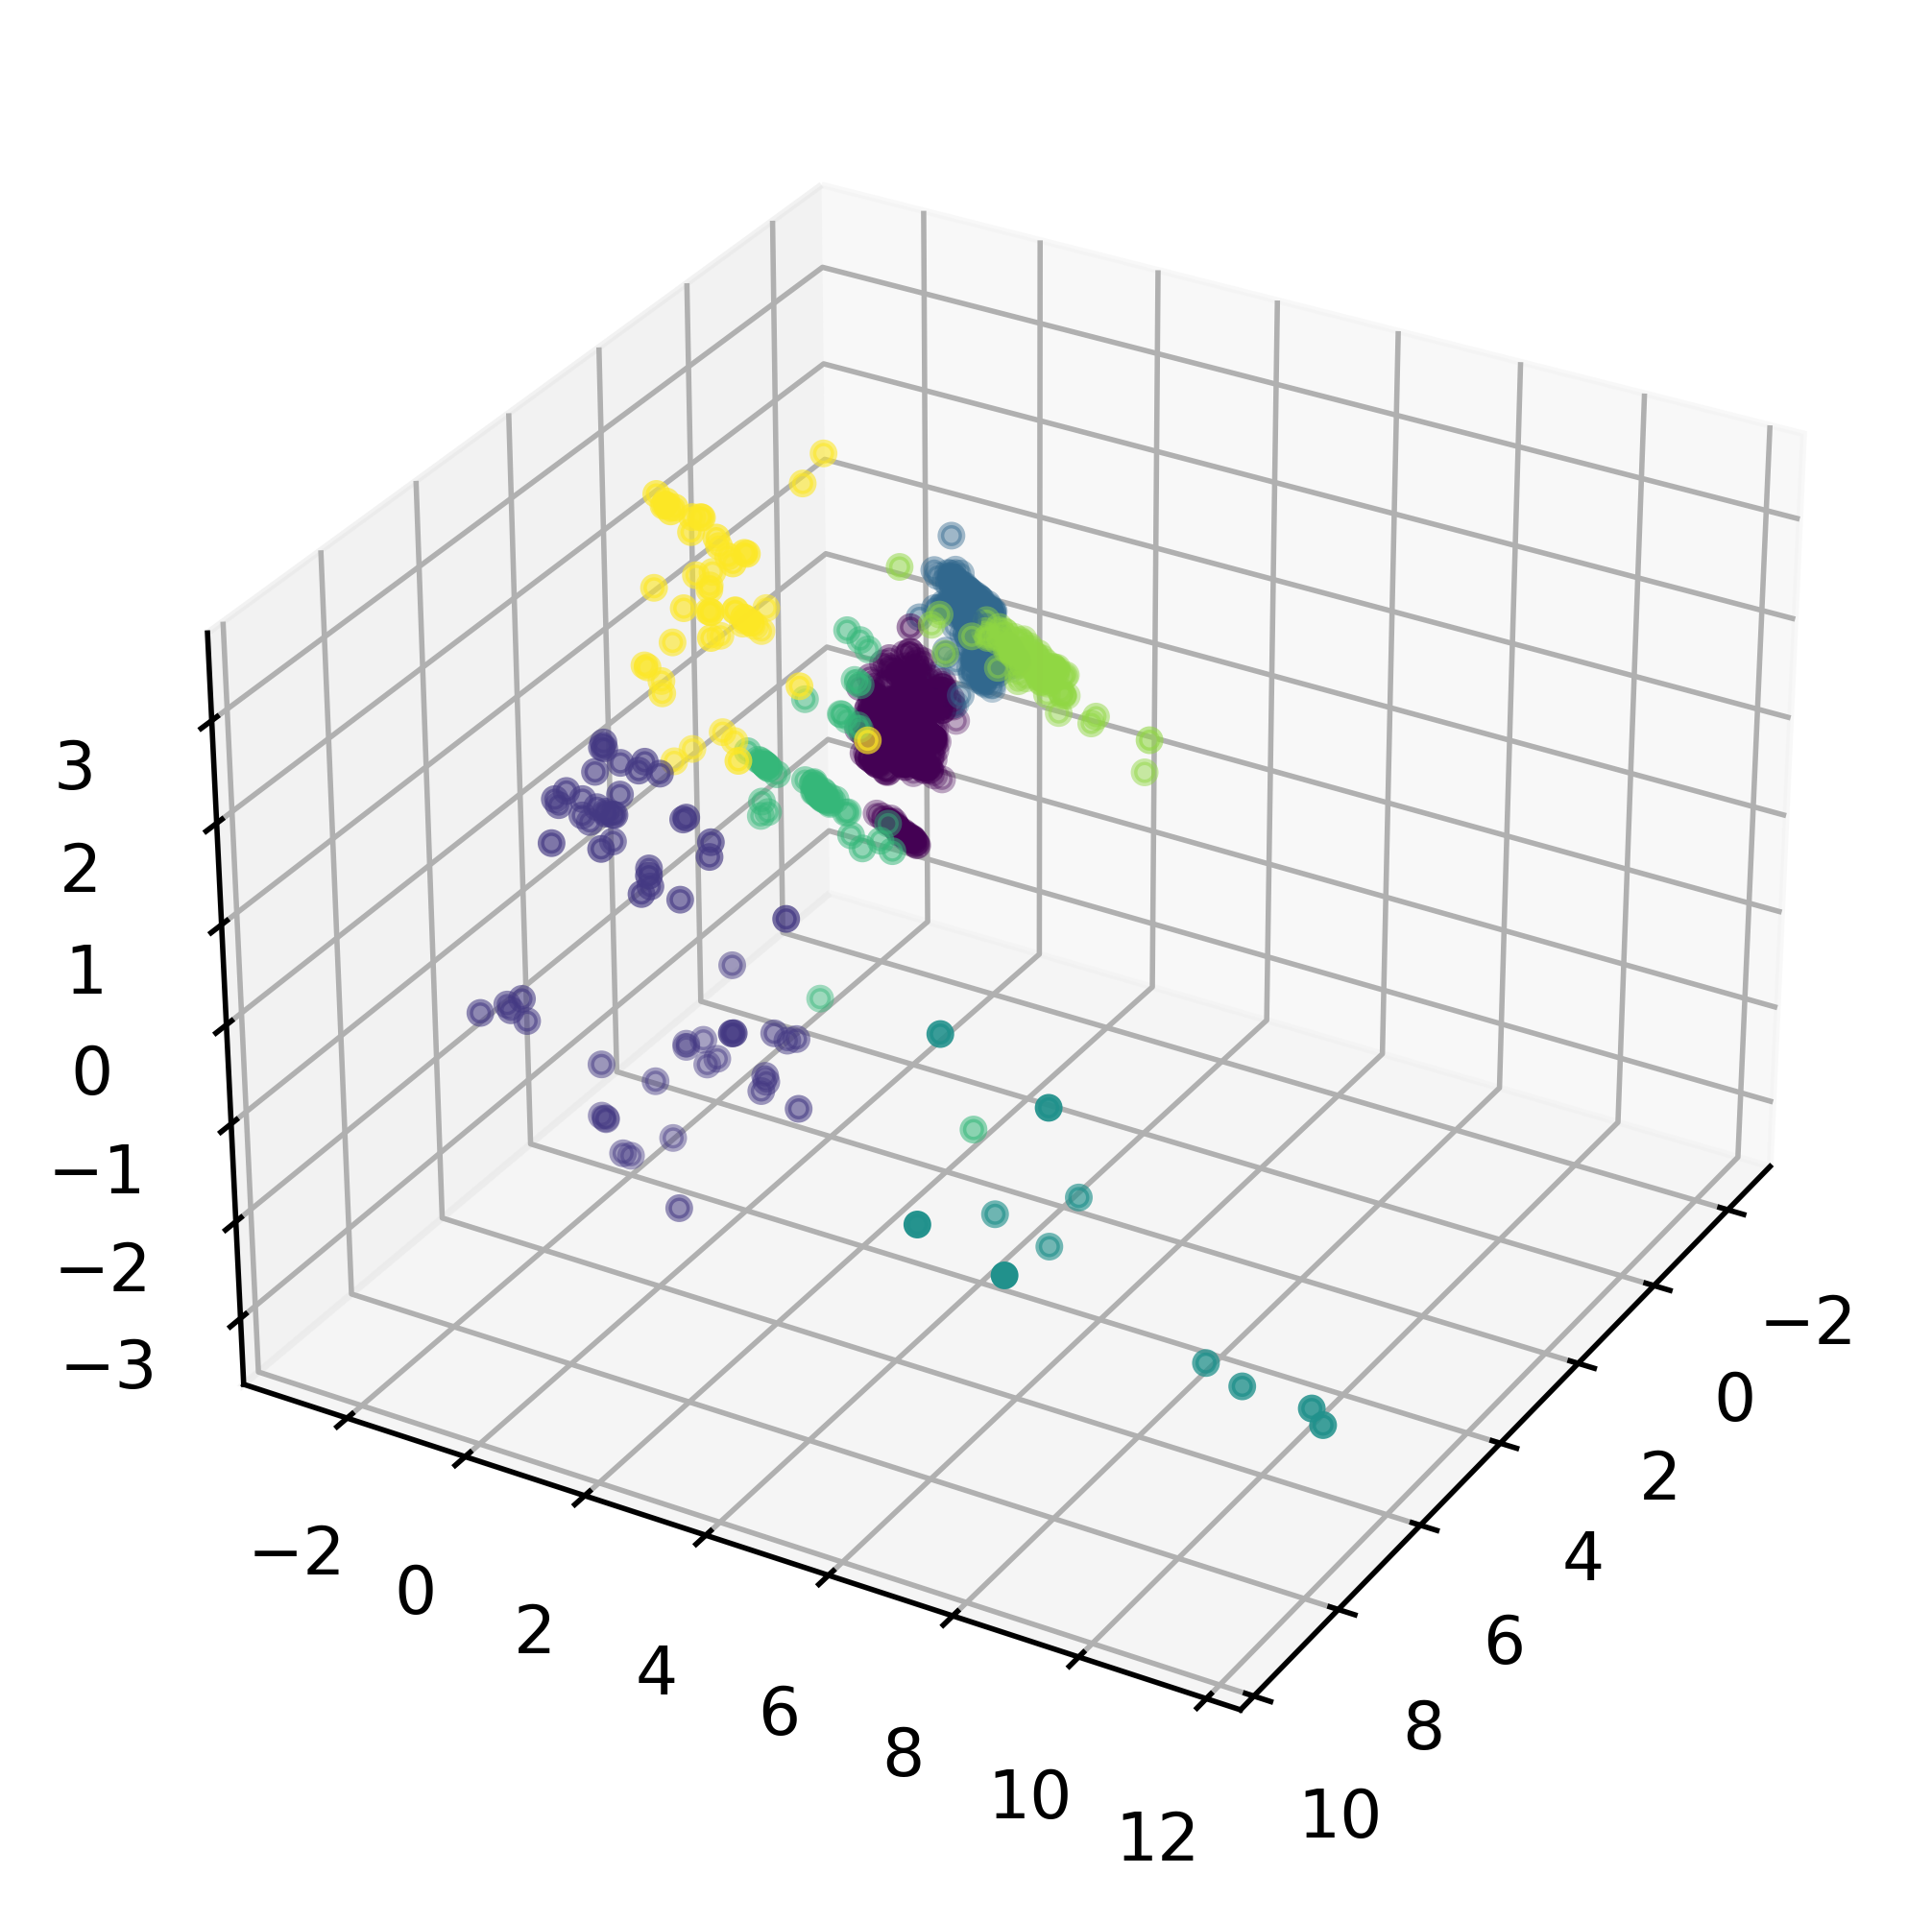

In [23]:
k = 7
kmeans = KMeans(n_clusters=k)

# Train
labels = kmeans.fit_predict(transformed_X)

# Plot cluster labels
fig = plt.figure()
ax = fig.add_subplot( projection='3d')
ax.scatter3D(transformed_X[:,0], transformed_X[:,1], transformed_X[:,2], s=10, c=labels)
ax.view_init(elev=30, azim=30)


Same plot from different perspectives.

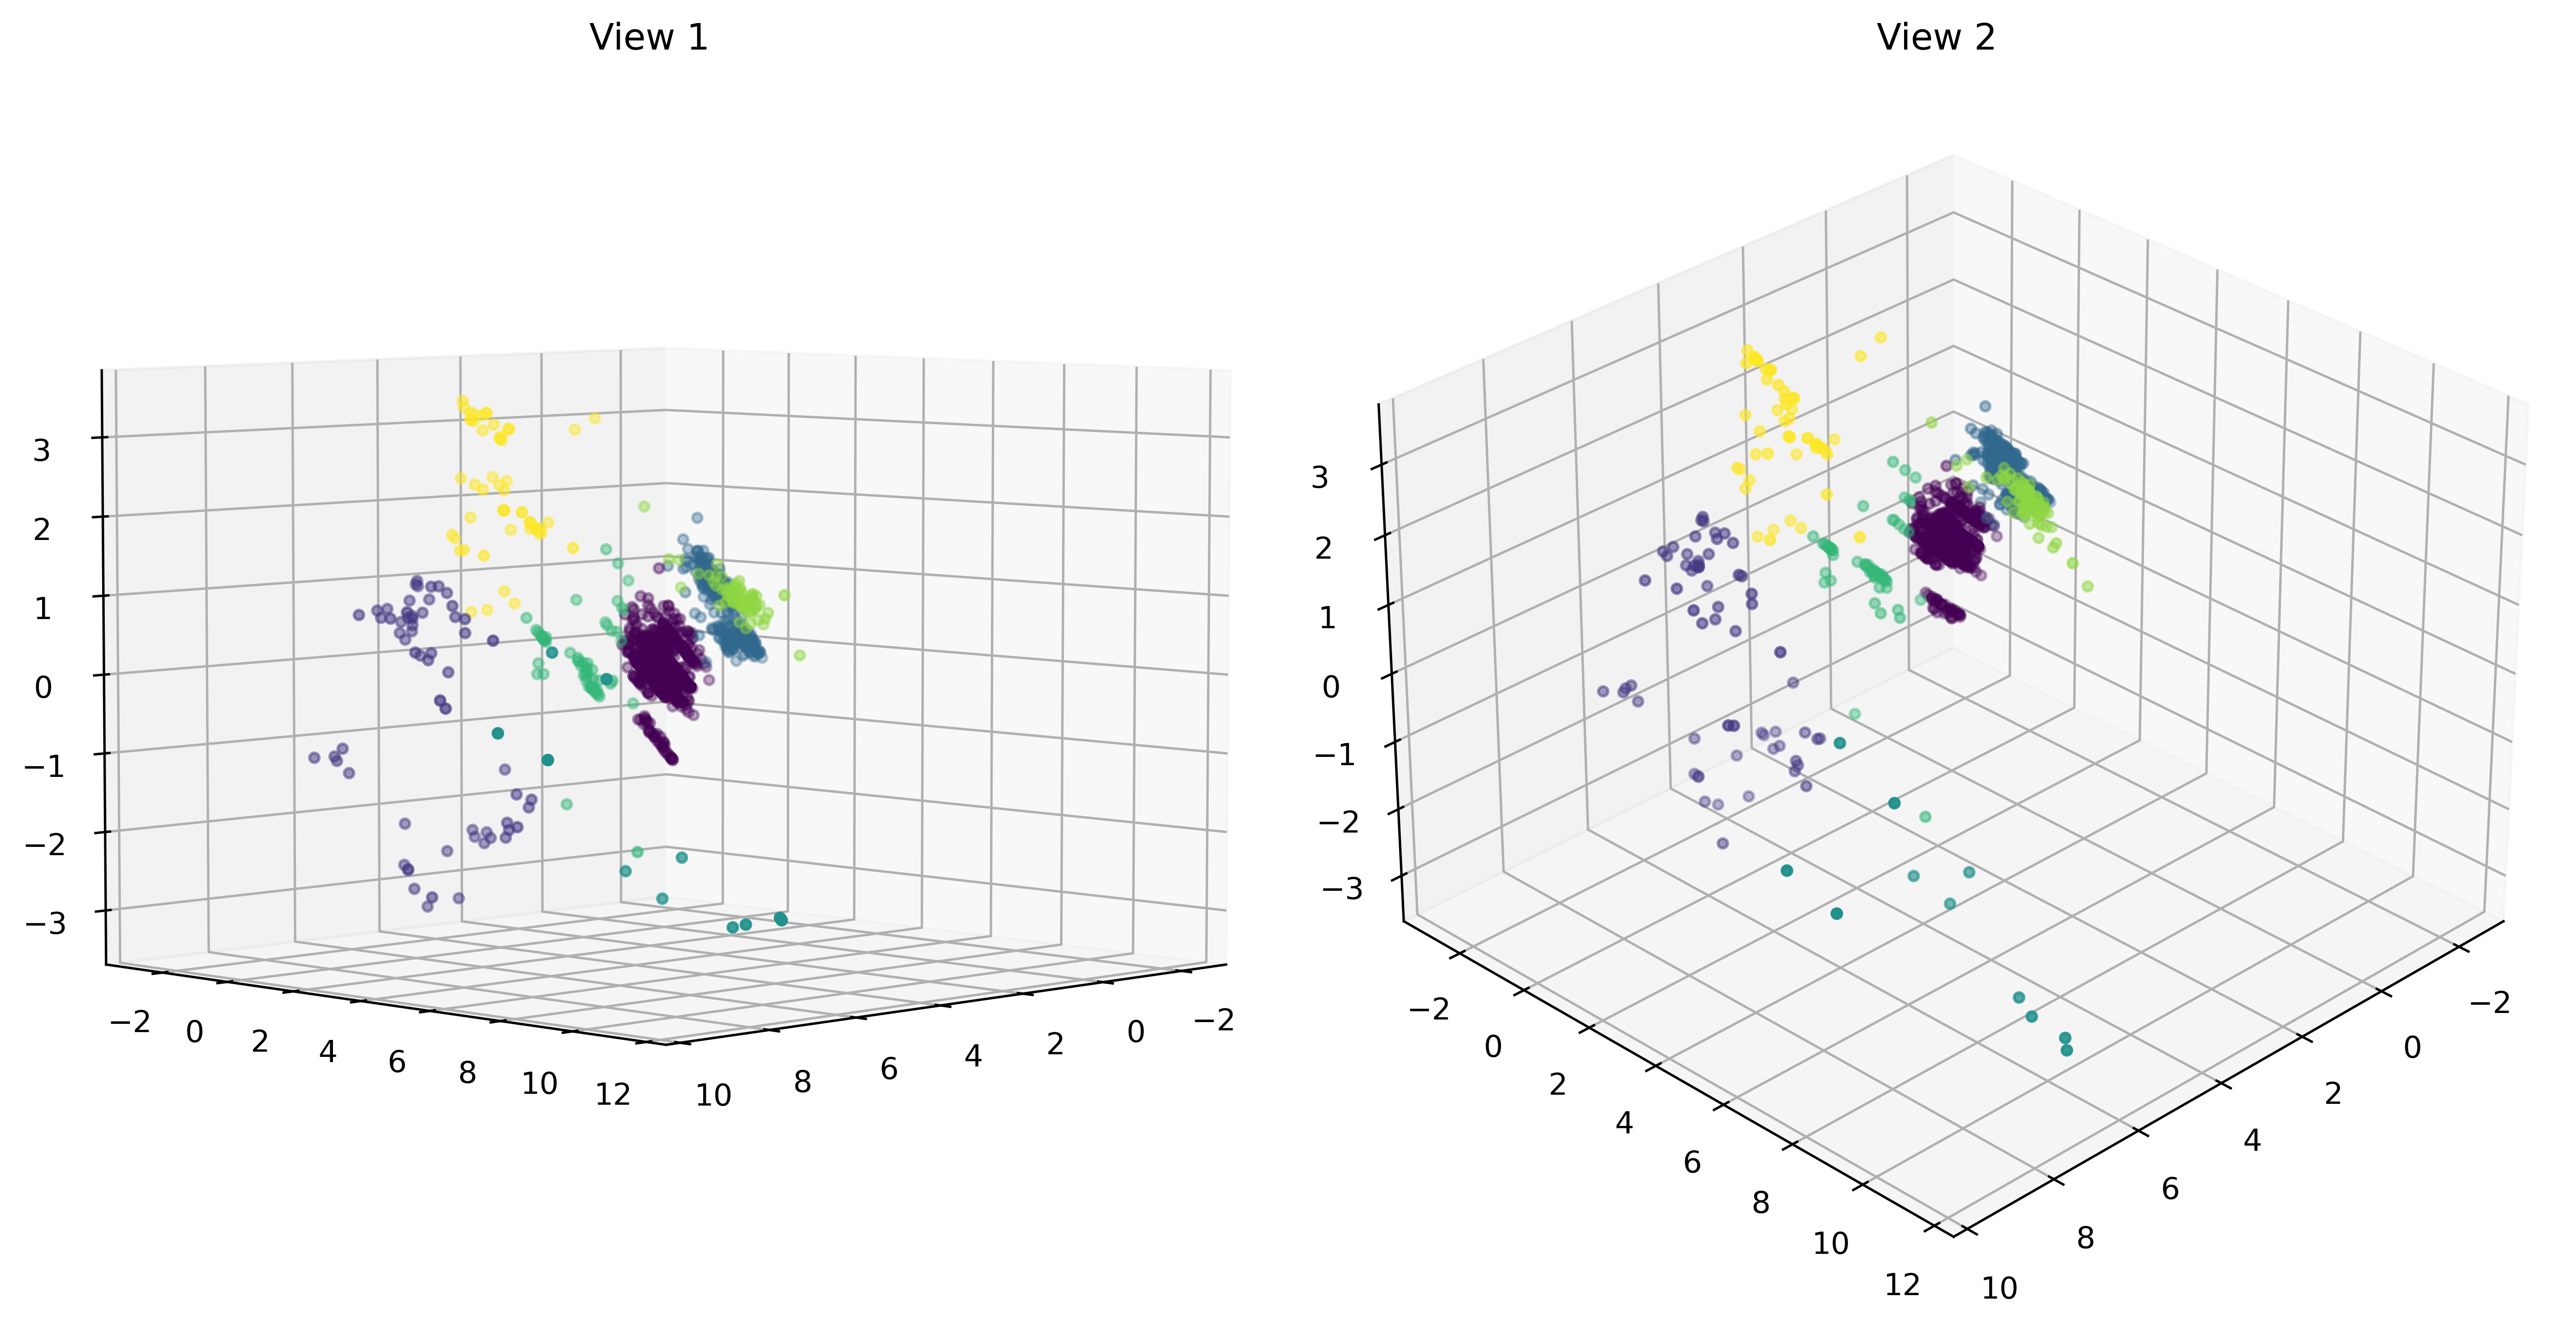

In [24]:
# Produce plots from different perspectives
fig = plt.figure(figsize=(12, 6))
elevations = [5, 30]
azimuths = [45, 45]

for i, (elevation, azimuth) in enumerate(zip(elevations, azimuths), 1):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    ax.scatter3D(transformed_X[:, 0], transformed_X[:, 1], transformed_X[:, 2], s=10, c=labels)
    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_title(f'View {i}')

plt.tight_layout()

The data in yellow, navy blue, and purple should belong to the same cluster, according to the plots. However, as will be discussed in next section, the physical description of the problem treated here reinforces the choice of k=7.

In [25]:
# Interactive plot of the clusters
fig = px.scatter_3d(transformed_X, x=transformed_X[:,0], y=transformed_X[:,1], z=transformed_X[:,2], color=labels, size_max=0.5)
fig.show()


## **6. Real-World Application**

The idea of applying clustering to earthquake data was to discover patterns between the clusters generated and the locations of each seismic event. Guided by this idea, we proceed to plot the data on the global map, considering the labels assigned by the KMeans clustering algorithm

In [27]:
# Get the coordinates for each Sismic event
coordinates = list(zip(list(reduced_df['latitude'].values), list(reduced_df['longitude'].values)))

# Calculate the center latitude and longitude
center_latitude = sum(lat for lat, lon in coordinates) / len(coordinates)
center_longitude = sum(lon for lat, lon in coordinates) / len(coordinates)

# Create a map centered at a specific location (e.g., latitude and longitude of the map center)
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=4)  # Adjust zoom level as needed

# Create a DataFrame sorted by the labels of each cluster
kmeans_df = pd.DataFrame({'latitude':X_scaled_df['latitude'],
                          'longitude':X_scaled_df['longitude'],
                          'label':labels
                          })

#normalized_coordinates = [(lat - center_latitude, lon - center_longitude) for lat, lon in coordinates]

# Iterate through your DataFrame containing the data with cluster labels
for index, row in kmeans_df.iterrows():
    # Get the latitude, longitude, and cluster label
    lat, lon, cluster_label = row['latitude'], row['longitude'], row['label']
    
    # Add a marker to the map for each data point with a different color based on the cluster label
    if cluster_label == 0:
        color = 'red'
    elif cluster_label == 1:
        color = 'blue'
    elif cluster_label == 2:
        color = 'green'
    elif cluster_label == 3:
        color = 'yellow'
    elif cluster_label == 4:
        color = 'purple'
    elif cluster_label == 5:
        color = 'orange'    
   
    
    # Use normalized_coordinates for location
    folium.CircleMarker(
        location=[coordinates[index][0], coordinates[index][1]],
        radius=5,  # Adjust the marker size
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=f'Cluster: {cluster_label}'  # Display cluster label on hover
    ).add_to(m)
# Save the map to an HTML file
m.save('../data/reports/maps/cluster_map.html')


The PDF contains a more in-depth discussion and interpretation of the results obtained.